# Introduction

Dans ce notebook, nous utilisons des réseaux de neurones récurrents. Néanmoins, étant donné que nous choisissons des séquences de taille unitaiure lors de l'apprentissage l'intérêt de la récurrence dans notre cas est limité.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
DATA_PATH = "../../data/clean/sud3_pm_normalized.pkl"

In [3]:
df = pd.read_pickle(DATA_PATH)
df = df.reset_index()
df = df.dropna()
df.head(10)

,index,date,ref,PM_6182,PM_6179,PM_617B,PM25_6182,PM25_6179,PM25_617B,rh,t_grad,pressure,temp,pluvio
0,15,2017-09-28 14:00:00,16.2,-1.179450,-1.139344,-1.135621,-1.184033,-1.129486,-1.149095,-1.118787,-0.921348,0.312759,1.982213,0.0
1,16,2017-09-28 14:15:00,9.6,-1.109019,-1.086416,-1.122920,-1.102387,-1.072487,-1.129116,-1.127870,-0.976013,0.331953,2.052982,0.0
2,17,2017-09-28 14:30:00,10.3,-1.179450,-1.171101,-1.258406,-1.177752,-1.169386,-1.253987,-1.236869,-1.085343,0.312759,2.076572,0.0
3,18,2017-09-28 14:45:00,9.4,-1.138365,-1.001731,-1.207599,-1.140070,-1.009787,-1.224018,-1.264119,-0.812018,0.312759,2.005803,0.0
4,19,2017-09-28 15:00:00,10.7,-1.167711,-1.165808,-1.139855,-1.165191,-1.169386,-1.149095,-1.146036,-0.921348,0.312759,1.864265,0.0
5,20,2017-09-28 15:15:00,10.7,-1.167711,-1.202857,-1.038241,-1.158911,-1.197885,-1.039208,-1.055204,-0.866683,0.312759,1.746317,0.0
6,21,2017-09-28 15:30:00,9.6,-1.079673,-1.171101,-1.008603,-1.070985,-1.163686,-0.999249,-0.964371,-0.812018,0.312759,1.651959,0.0
7,22,2017-09-28 15:45:00,10.2,-1.032720,-1.134051,-0.995901,-1.033302,-1.123786,-0.989259,-0.891705,-0.757353,0.312759,1.581190,0.0
8,23,2017-09-28 16:00:00,9.8,-1.044458,-1.097001,-0.911222,-1.039583,-1.095286,-0.919331,-0.855372,-0.757353,0.312759,1.534011,0.0
9,24,2017-09-28 16:15:00,8.9,-1.044458,-1.044073,-1.182195,-1.039583,-1.038287,-1.174070,-0.855372,-0.702688,0.331953,1.486832,0.0


In [4]:
def split_dataframe(dataframe, percent):
    nb_rows = int(np.floor(percent * len(dataframe)))
    return dataframe[:nb_rows], dataframe[nb_rows:]

def dataframe_to_xy(df):
    return (np.array(df[['PM_6182', 'PM_6179', 'PM_617B', 'PM25_6182', 'PM25_6179', 'PM25_617B', 'temp', 'rh',\
                         't_grad', 'pressure', 'pluvio']]),\
            np.array(df['ref']))
       
df_train, df_test = split_dataframe(df, 0.5) 
df_valid, df_test = split_dataframe(df_test, 0.5)

X_train, y_train = dataframe_to_xy(df_train)
X_valid, y_valid = dataframe_to_xy(df_valid)
X_test, y_test = dataframe_to_xy(df_test)

# On reshape les données pour matcher avec les modèles récurrents de keras

X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_valid= X_valid.reshape((X_valid.shape[0], 1,  X_valid.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

In [5]:
### Distribution des données sur les 3 jeux de validation croisée

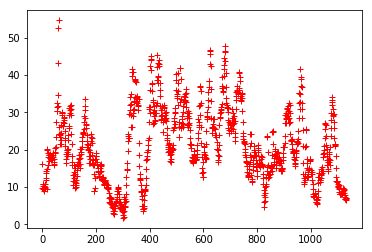

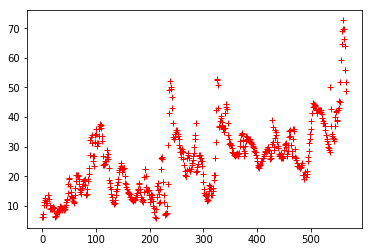

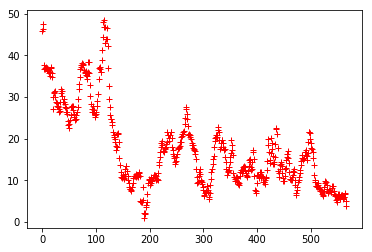

In [6]:
plt.plot(y_train, '+r')
plt.show()
plt.plot(y_valid, '+r')
plt.show()
plt.plot(y_test, '+r')
plt.show()

# Définition des modèles (RNN, LSTM, GRU)

In [7]:
from keras.layers import SimpleRNN, Dense, LSTM, GRU
from keras.models import Sequential
from keras.callbacks import EarlyStopping

def simple_rnn_model(nb_units, input_dim, loss='mean_squared_error', optimizer='adam'):
    model = Sequential()
    model.add(SimpleRNN(nb_units, input_shape=input_dim, recurrent_dropout=1, activation='relu'))#, recurrent_dropout=1))
    model.add(Dense(nb_units, activation='relu'))
    model.add(Dense(1, kernel_initializer='normal', activation='relu'))
    model.compile(loss=loss, optimizer=optimizer)
    model.summary()
    return model

def lstm_model(nb_units, input_dim, loss='mean_squared_error', optimizer='adam', activation='relu'):
    model = Sequential()
    model.add(LSTM(nb_units, input_shape=input_dim, activation='relu'))
    model.add(Dense(nb_units, activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    model.compile(loss=loss, optimizer=optimizer)
    model.summary()
    return model

def gru_model(nb_units, input_dim, loss='mean_squared_error', optimizer='adam', activation='relu'):
    model = Sequential()
    model.add(GRU(nb_units, input_shape=input_dim, activation='relu'))
    model.add(Dense(nb_units, activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    model.compile(loss=loss, optimizer=optimizer)
    model.summary()
    return model

Using TensorFlow backend.


## Simple RNN

### Apprentissage

In [8]:
model = simple_rnn_model(32, X_train.shape[1:])
early_stopping = EarlyStopping(monitor='val_loss', verbose=1, mode='auto', patience=25)
history = model.fit(X_train, y_train, batch_size=32, epochs=10000, validation_data=(X_valid, y_valid), callbacks=[early_stopping], verbose=1, shuffle=False)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_1 (SimpleRNN)     (None, 32)                1408      
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 2,497
Trainable params: 2,497
Non-trainable params: 0
_________________________________________________________________
Train on 1133 samples, validate on 567 samples
Epoch 1/10000
1133/1133 [==============================] - 0s 170us/step - loss: 524.1086 - val_loss: 754.3497
Epoch 2/10000
1133/1133 [==============================] - 0s 44us/step - loss: 500.9824 - val_loss: 716.4915
Epoch 3/10000
1133/1133 [==============================] - 0s 44us/step - loss: 454.0147 - val_loss: 635.6660
Epoch 4/10000
1133/1133 [=

1133/1133 [==============================] - 0s 44us/step - loss: 40.0055 - val_loss: 135.3942
Epoch 69/10000
1133/1133 [==============================] - 0s 45us/step - loss: 39.8832 - val_loss: 135.0437
Epoch 70/10000
1133/1133 [==============================] - 0s 46us/step - loss: 39.7632 - val_loss: 134.7629
Epoch 71/10000
1133/1133 [==============================] - 0s 43us/step - loss: 39.6482 - val_loss: 134.4027
Epoch 72/10000
1133/1133 [==============================] - 0s 44us/step - loss: 39.5338 - val_loss: 134.0972
Epoch 73/10000
1133/1133 [==============================] - 0s 44us/step - loss: 39.4231 - val_loss: 133.7641
Epoch 74/10000
1133/1133 [==============================] - 0s 44us/step - loss: 39.3159 - val_loss: 133.4550
Epoch 75/10000
1133/1133 [==============================] - 0s 44us/step - loss: 39.2112 - val_loss: 133.1361
Epoch 76/10000
1133/1133 [==============================] - 0s 43us/step - loss: 39.1115 - val_loss: 132.8001
Epoch 77/10000
1133/1133 

1133/1133 [==============================] - 0s 45us/step - loss: 34.2420 - val_loss: 120.3249
Epoch 143/10000
1133/1133 [==============================] - 0s 45us/step - loss: 34.1790 - val_loss: 120.3096
Epoch 144/10000
1133/1133 [==============================] - 0s 44us/step - loss: 34.1170 - val_loss: 120.2276
Epoch 145/10000
1133/1133 [==============================] - 0s 44us/step - loss: 34.0519 - val_loss: 120.2607
Epoch 146/10000
1133/1133 [==============================] - 0s 43us/step - loss: 33.9905 - val_loss: 120.2234
Epoch 147/10000
1133/1133 [==============================] - 0s 43us/step - loss: 33.9263 - val_loss: 120.1548
Epoch 148/10000
1133/1133 [==============================] - 0s 44us/step - loss: 33.8631 - val_loss: 120.1431
Epoch 149/10000
1133/1133 [==============================] - 0s 43us/step - loss: 33.8034 - val_loss: 120.0948
Epoch 150/10000
1133/1133 [==============================] - 0s 45us/step - loss: 33.7359 - val_loss: 120.0380
Epoch 151/10000
1

### Courbes de résultats pour modèle RNN

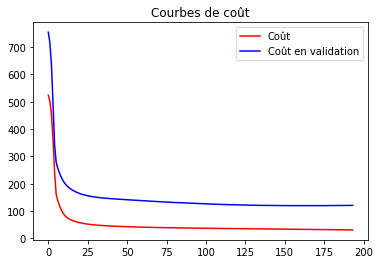

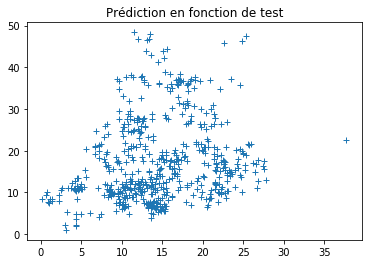

In [9]:
y_pred = model.predict(X_test)
plt.plot(history.history['loss'], 'r-', label="Coût")
plt.plot(history.history['val_loss'], 'b-', label="Coût en validation")
plt.title("Courbes de coût")
plt.legend()
plt.show()

plt.title('y_pred, y_test')

plt.plot(y_pred[:], y_test[:], '+')
plt.title("Prédiction en fonction de test")
plt.show()

## LSTM

### Apprentissage

In [10]:
model = lstm_model(32, X_train.shape[1:])
early_stopping = EarlyStopping(monitor='val_loss', verbose=1, mode='auto', patience=25)
history = model.fit(X_train, y_train, batch_size=32, epochs=10000, validation_data=(X_valid, y_valid), callbacks=[early_stopping], verbose=1, shuffle=False)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 32)                5632      
_________________________________________________________________
dense_3 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 33        
Total params: 6,721
Trainable params: 6,721
Non-trainable params: 0
_________________________________________________________________
Train on 1133 samples, validate on 567 samples
Epoch 1/10000
1133/1133 [==============================] - 0s 314us/step - loss: 532.8609 - val_loss: 770.3542
Epoch 2/10000
1133/1133 [==============================] - 0s 73us/step - loss: 524.8606 - val_loss: 753.3384
Epoch 3/10000
1133/1133 [==============================] - 0s 64us/step - loss: 501.2284 - val_loss: 703.4920
Epoch 4/10000
1133/1133 [=

1133/1133 [==============================] - 0s 65us/step - loss: 37.1194 - val_loss: 115.2986
Epoch 69/10000
1133/1133 [==============================] - 0s 63us/step - loss: 36.9923 - val_loss: 115.1180
Epoch 70/10000
1133/1133 [==============================] - 0s 65us/step - loss: 36.8679 - val_loss: 114.9781
Epoch 71/10000
1133/1133 [==============================] - 0s 63us/step - loss: 36.7426 - val_loss: 114.8712
Epoch 72/10000
1133/1133 [==============================] - 0s 63us/step - loss: 36.6156 - val_loss: 114.7400
Epoch 73/10000
1133/1133 [==============================] - 0s 63us/step - loss: 36.4998 - val_loss: 114.6551
Epoch 74/10000
1133/1133 [==============================] - 0s 65us/step - loss: 36.3889 - val_loss: 114.5999
Epoch 75/10000
1133/1133 [==============================] - 0s 62us/step - loss: 36.2805 - val_loss: 114.5653
Epoch 76/10000
1133/1133 [==============================] - 0s 62us/step - loss: 36.1769 - val_loss: 114.5434
Epoch 77/10000
1133/1133 

### Courbes de résultats pour modèle LSTM

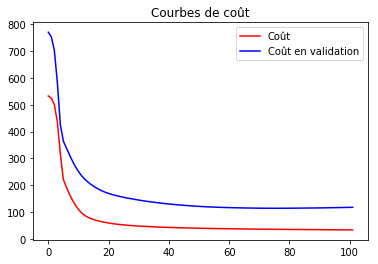

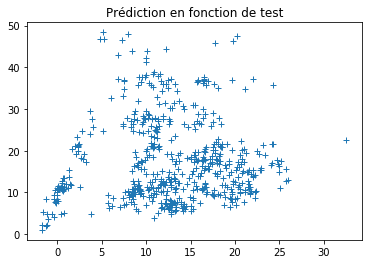

In [11]:
y_pred = model.predict(X_test)
plt.plot(history.history['loss'], 'r-', label="Coût")
plt.plot(history.history['val_loss'], 'b-', label="Coût en validation")
plt.title("Courbes de coût")
plt.legend()
plt.show()

plt.title('y_pred, y_test')

plt.plot(y_pred[:], y_test[:], '+')
plt.title("Prédiction en fonction de test")
plt.show()

## GRU

### Apprentissage

In [12]:
model = gru_model(32, X_train.shape[1:])
early_stopping = EarlyStopping(monitor='val_loss', verbose=1, mode='auto', patience=10)
history = model.fit(X_train, y_train, batch_size=32, epochs=10000, validation_data=(X_valid, y_valid), callbacks=[early_stopping], verbose=1, shuffle=False)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, 32)                4224      
_________________________________________________________________
dense_5 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 33        
Total params: 5,313
Trainable params: 5,313
Non-trainable params: 0
_________________________________________________________________
Train on 1133 samples, validate on 567 samples
Epoch 1/10000
1133/1133 [==============================] - 0s 330us/step - loss: 531.4142 - val_loss: 766.9969
Epoch 2/10000
1133/1133 [==============================] - 0s 60us/step - loss: 519.2263 - val_loss: 739.5810
Epoch 3/10000
1133/1133 [==============================] - 0s 59us/step - loss: 481.1870 - val_loss: 658.3857
Epoch 4/10000
1133/1133 [=

1133/1133 [==============================] - 0s 67us/step - loss: 40.0313 - val_loss: 117.9000
Epoch 69/10000
1133/1133 [==============================] - 0s 66us/step - loss: 39.8903 - val_loss: 117.5386
Epoch 70/10000
1133/1133 [==============================] - 0s 61us/step - loss: 39.7500 - val_loss: 117.1984
Epoch 71/10000
1133/1133 [==============================] - 0s 61us/step - loss: 39.6142 - val_loss: 116.8704
Epoch 72/10000
1133/1133 [==============================] - 0s 62us/step - loss: 39.4801 - val_loss: 116.5440
Epoch 73/10000
1133/1133 [==============================] - 0s 60us/step - loss: 39.3495 - val_loss: 116.2318
Epoch 74/10000
1133/1133 [==============================] - 0s 62us/step - loss: 39.2190 - val_loss: 115.9537
Epoch 75/10000
1133/1133 [==============================] - 0s 62us/step - loss: 39.0915 - val_loss: 115.6880
Epoch 76/10000
1133/1133 [==============================] - 0s 61us/step - loss: 38.9697 - val_loss: 115.4218
Epoch 77/10000
1133/1133 

### Courbes de résultats pour modèle GRU

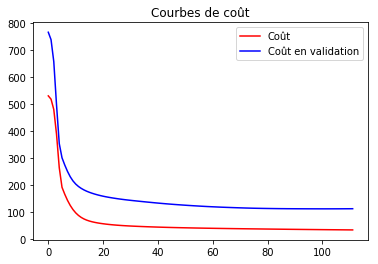

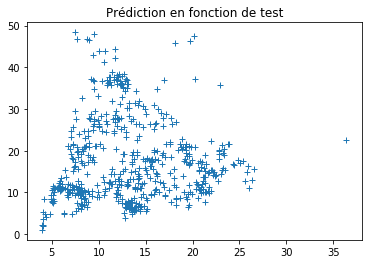

In [13]:
y_pred = model.predict(X_test)
plt.plot(history.history['loss'], 'r-', label="Coût")
plt.plot(history.history['val_loss'], 'b-', label="Coût en validation")
plt.title("Courbes de coût")
plt.legend()
plt.show()

plt.title('y_pred, y_test')

plt.plot(y_pred[:], y_test[:], '+')
plt.title("Prédiction en fonction de test")
plt.show()

# Conclusion

Dans ce notebook, nous n'avons pas pu exploité la force des réseaux récurrents qui sont performants sur des données séquentiels, par la prise en compte de séquence unitaire. Dans le notebook suivant, nous essaierons des modèles avec mémoire en prenant en compte de véritables séquences lors de l'apprentissage